In [1]:
from ciw.dists import Exponential
from kmodes.kprototypes import KPrototypes
from scipy import special, stats
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from yellowbrick.utils import KneeLocator

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("default")
plt.style.use("seaborn-colorblind")

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']


In [3]:
copd = pd.read_csv(
    "/Volumes/thesis-data/copd.csv", parse_dates=["admission_date", "discharge_date"]
)


In [4]:
for col in copd.columns:
    if copd[col].isnull().sum() > .25 * len(copd):
        copd = copd.drop(col, axis=1)

copd = copd[copd["true_los"] <= 365]
copd = copd.dropna()


In [7]:
clinicals = [
    "n_spells",
    "n_wards",
    "n_consultants",
    "true_los",
    "n_pr_attendances",
    "n_sn_attendances",
    "n_copd_admissions_last_year",
    "charlson_gross",
    "n_icds",
    "intervention",
    "day_of_week",
    "gender",
]

codes = [
    "infectious",
    "neoplasms",
    "blood",
    "endocrine",
    "mental",
    "nervous",
    "eye",
    "ear",
    "circulatory",
    "respiratory",
    "digestive",
    "skin",
    "muscoloskeletal",
    "genitourinary",
    "perinatal",
    "congenital",
    "abnormal_findings",
    "injury",
    "external_causes", 
    "contact_factors",
    "special_use",
]

conditions = [
    "ami",
    "cva",
    "chf",
    "ctd",
    "dementia",
    "diabetes",
    "liver_disease",
    "peptic_ulcer",
    "pvd",
    "pulmonary_disease",
    "cancer",
    "diabetic_complications",
    "paraplegia",
    "renal_disease",
    "metastatic_cancer",
    "sever_liver_disease",
    "hiv",
    "cdiff",
    "mrsa",
    "obese",
    "sepsis",
]

cols = clinicals + codes + conditions
data = copd[cols].copy()

categorical = [
    i
    for i, (col, dtype) in enumerate(dict(data.dtypes).items())
    if dtype == "object"
]


In [27]:
# # APPROX. 40 minute runtime.

# knee_results = []
# cluster_range = range(2, 9)
# for n_clusters in tqdm(cluster_range):

#     kp = KPrototypes(n_clusters, init="cao", random_state=0, n_jobs=6)
#     kp.fit(data, categorical=categorical)

#     knee_results.append(kp.cost_)

100%|██████████| 7/7 [07:54<00:00, 73.71s/it]


In [29]:
# kl = KneeLocator(
#     cluster_range,
#     knee_results,
#     curve_nature="convex",
#     curve_direction="decreasing",
# )

# n_clusters = kl.knee

# with open("../data/n_clusters.txt", "w") as f:
#     f.write(str(n_clusters))

# knee_results = pd.Series(index=cluster_range, data=knee_results)
# knee_results.to_csv("../data/knee_results.csv", header=False)

In [91]:
knee_results = pd.read_csv("../data/knee_results.csv", header=None).set_index(0)
with open("../data/n_clusters.txt", "r") as f:
    n_clusters = int(f.read())

Text(0, 0.5, 'Final cost')

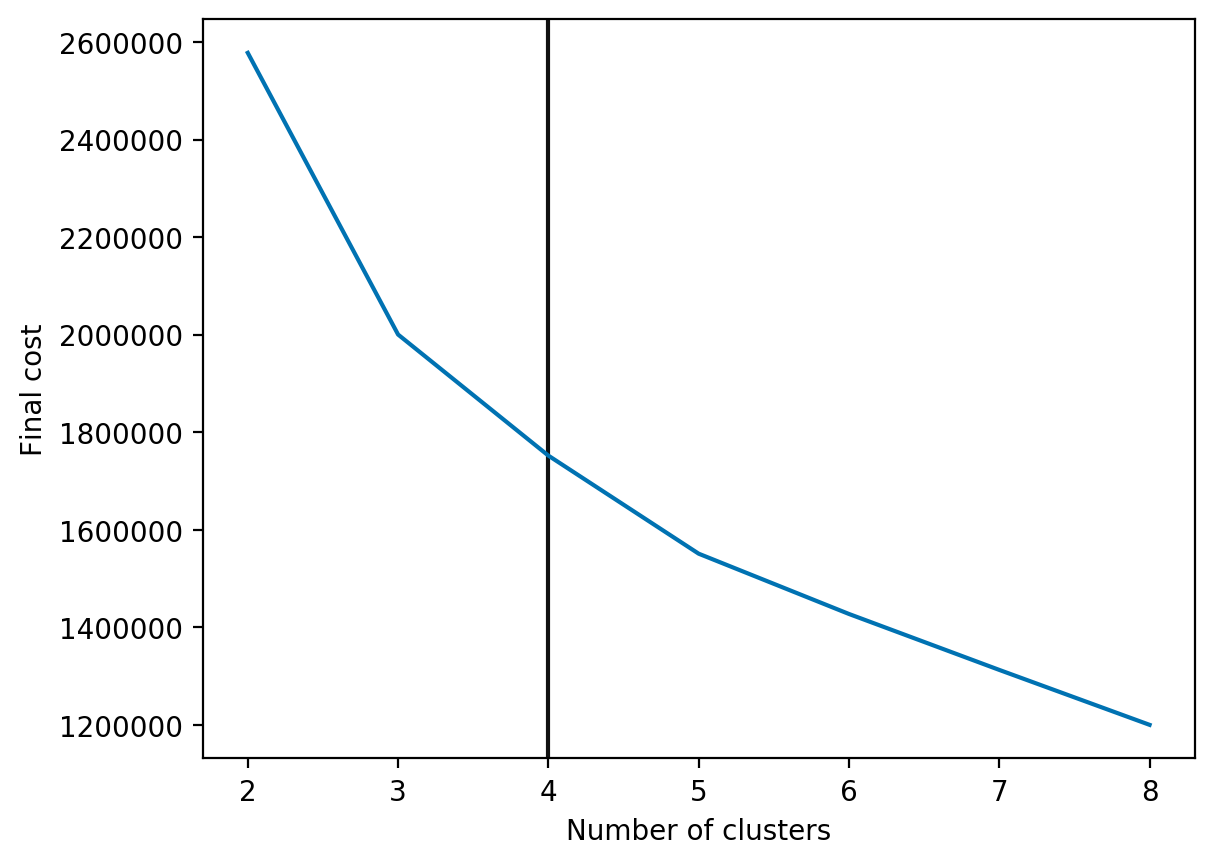

In [7]:
fig, ax = plt.subplots(dpi=200)

ax.plot(knee_results.index, knee_results.values)

ylims = ax.get_ylim()
ax.vlines(n_clusters, *ylims)
ax.set_ylim(*ylims)

ax.set_xlabel("Number of clusters")
ax.set_ylabel("Final cost")


In [33]:
# kp = KPrototypes(n_clusters, init="matching", random_state=0, n_jobs=6, verbose=1)
# kp.fit(data, categorical=categorical)

# labels = kp.labels_
# copd["cluster"] = labels
# copd.to_csv("../data/copd_clustered.csv", index=False)

# knee_results.loc[n_clusters, 1], kp.cost_

Best run was number 2


In [2]:
copd = pd.read_csv("../data/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"])

In [3]:
copd["cluster"].value_counts()

2    7534
1    2096
0    1080
3     157
Name: cluster, dtype: int64

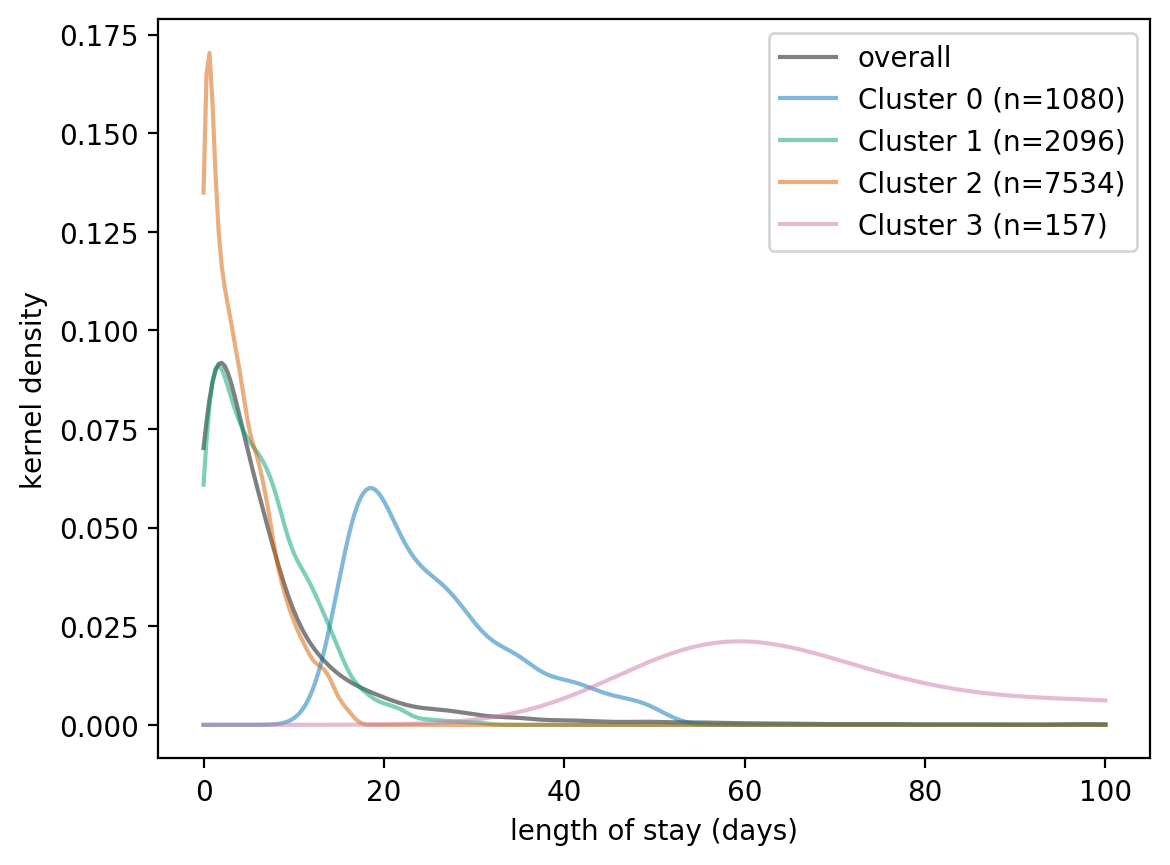

In [4]:
fig, ax = plt.subplots(dpi=200)

xs = np.linspace(0, 100, 300)
kernel = stats.gaussian_kde(copd["true_los"])
ax.plot(xs, kernel(xs), "gray", label="overall")

for cluster, times in copd.groupby("cluster")["true_los"]:

    colour = colours[cluster]
    kernel = stats.gaussian_kde(times)
    ax.plot(
        xs,
        kernel(xs),
        alpha=0.5,
        color=colour,
        label=f"Cluster {cluster} (n={len(times)})",
    )

ax.set_xlabel("length of stay (days)")
ax.set_ylabel("kernel density")

ax.legend()


In [5]:
def histograms(data, column, density=True, colours=colours):

    fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
    axes = axes.reshape(4)

    for (cluster, values), ax in zip(copd.groupby("cluster")[column], axes):

        ax.hist(
            copd[column],
            bins=9,
            facecolor="gray",
            alpha=0.2,
            density=True,
            label="overall",
        )

        colour = colours[cluster]
        ax.hist(values, alpha=0.5, facecolor=colour, density=True, label=cluster)

        ax.set_xlabel(" ".join(column.split("_")))
        ax.set_ylabel("frequency density")

        ax.legend()

    plt.tight_layout()

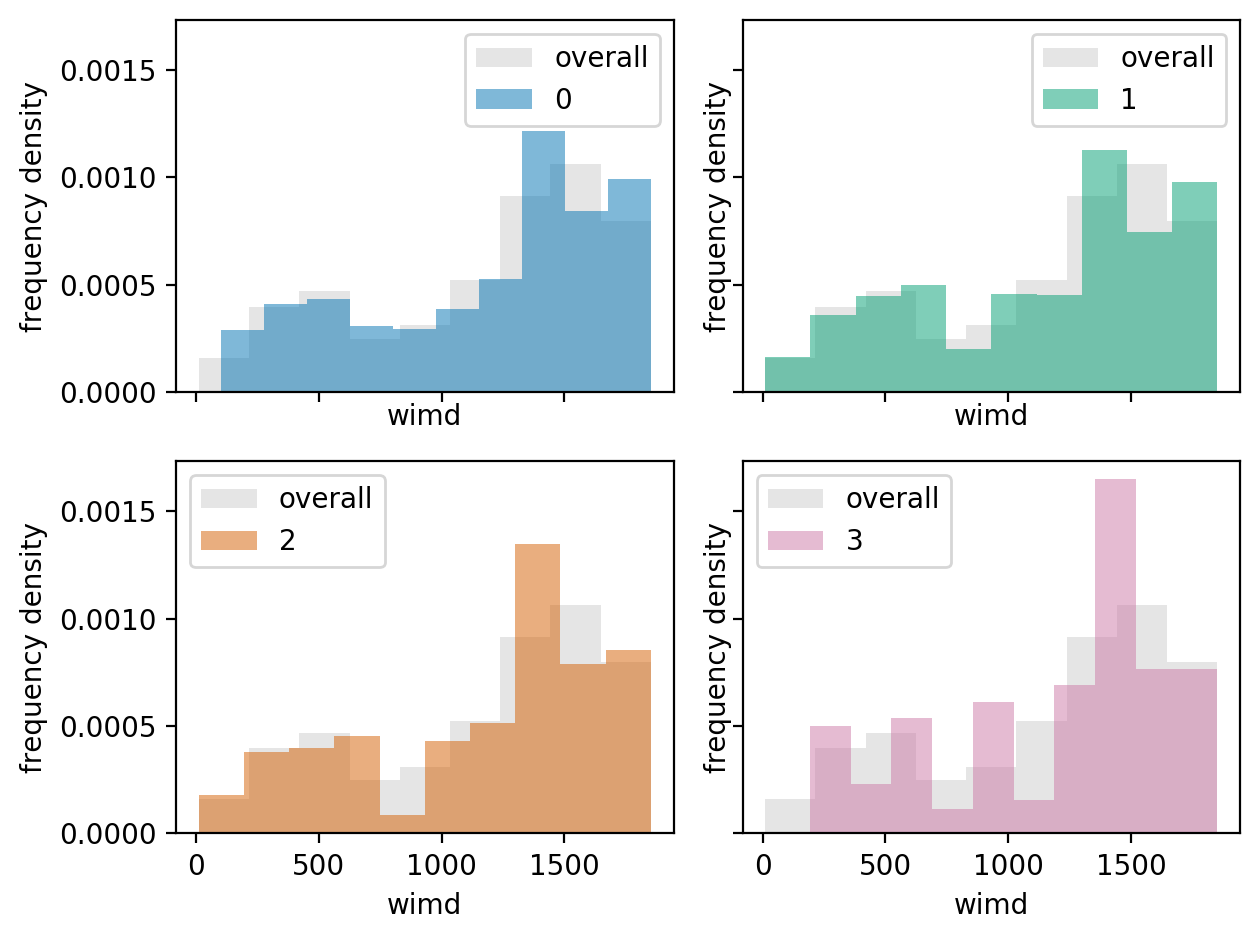

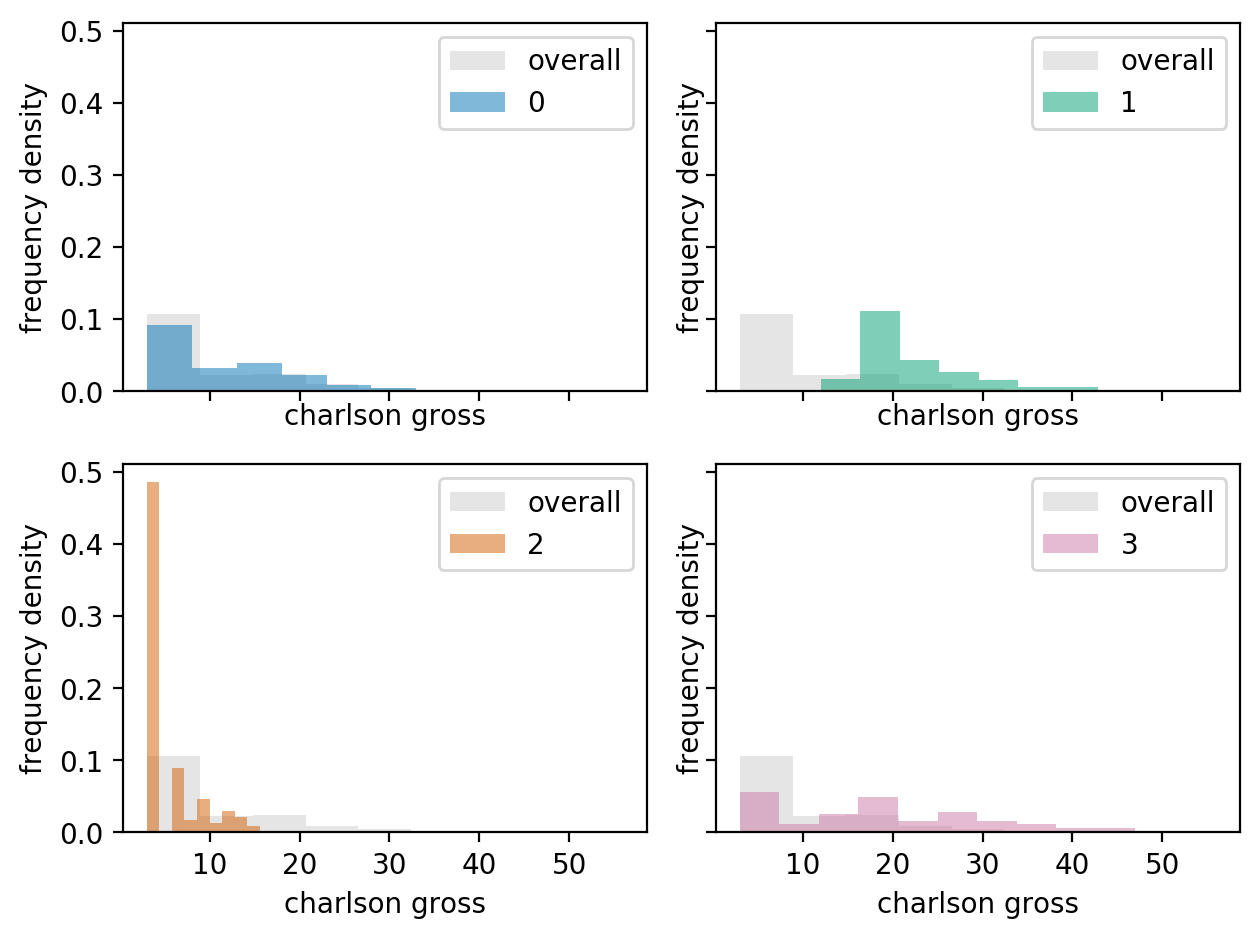

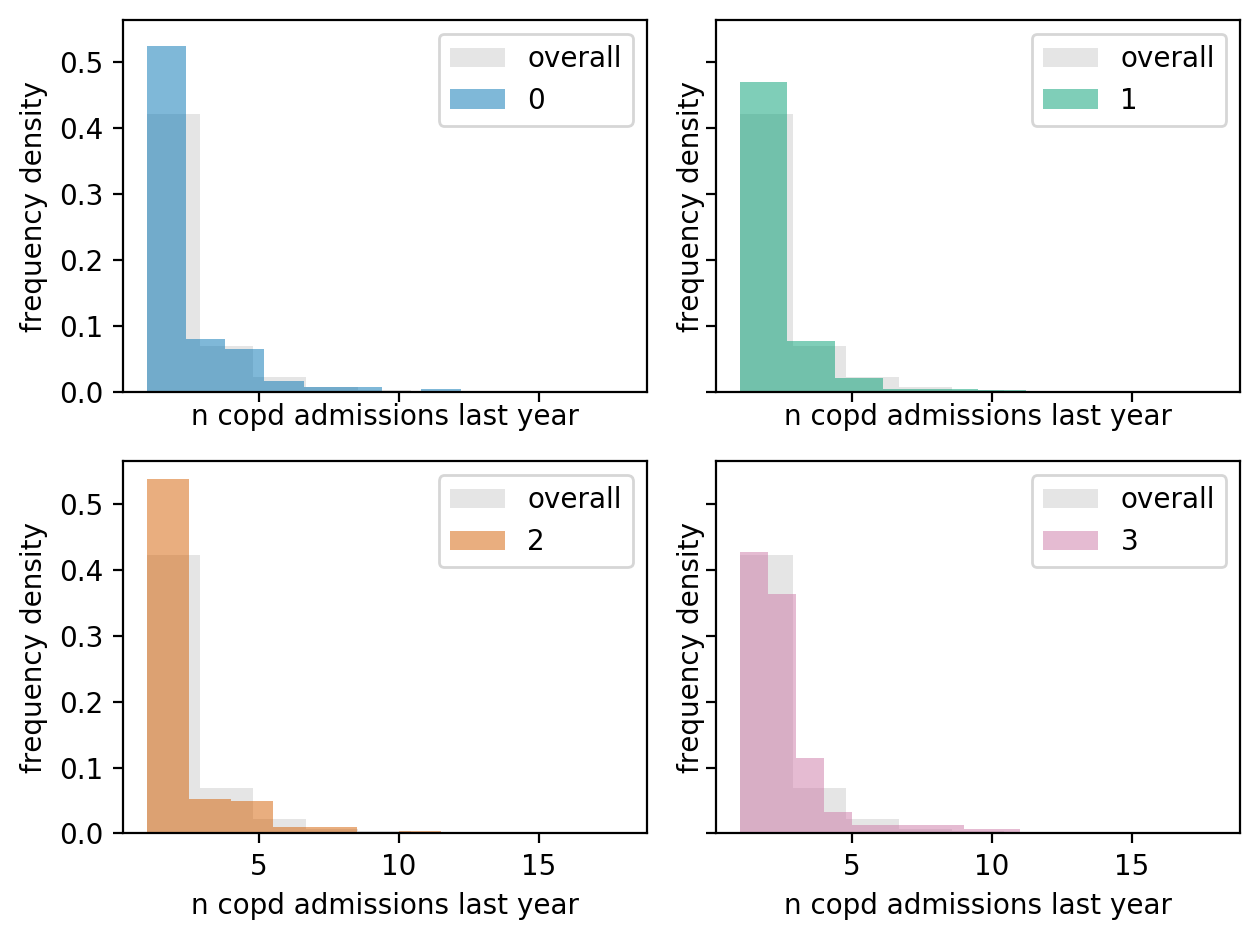

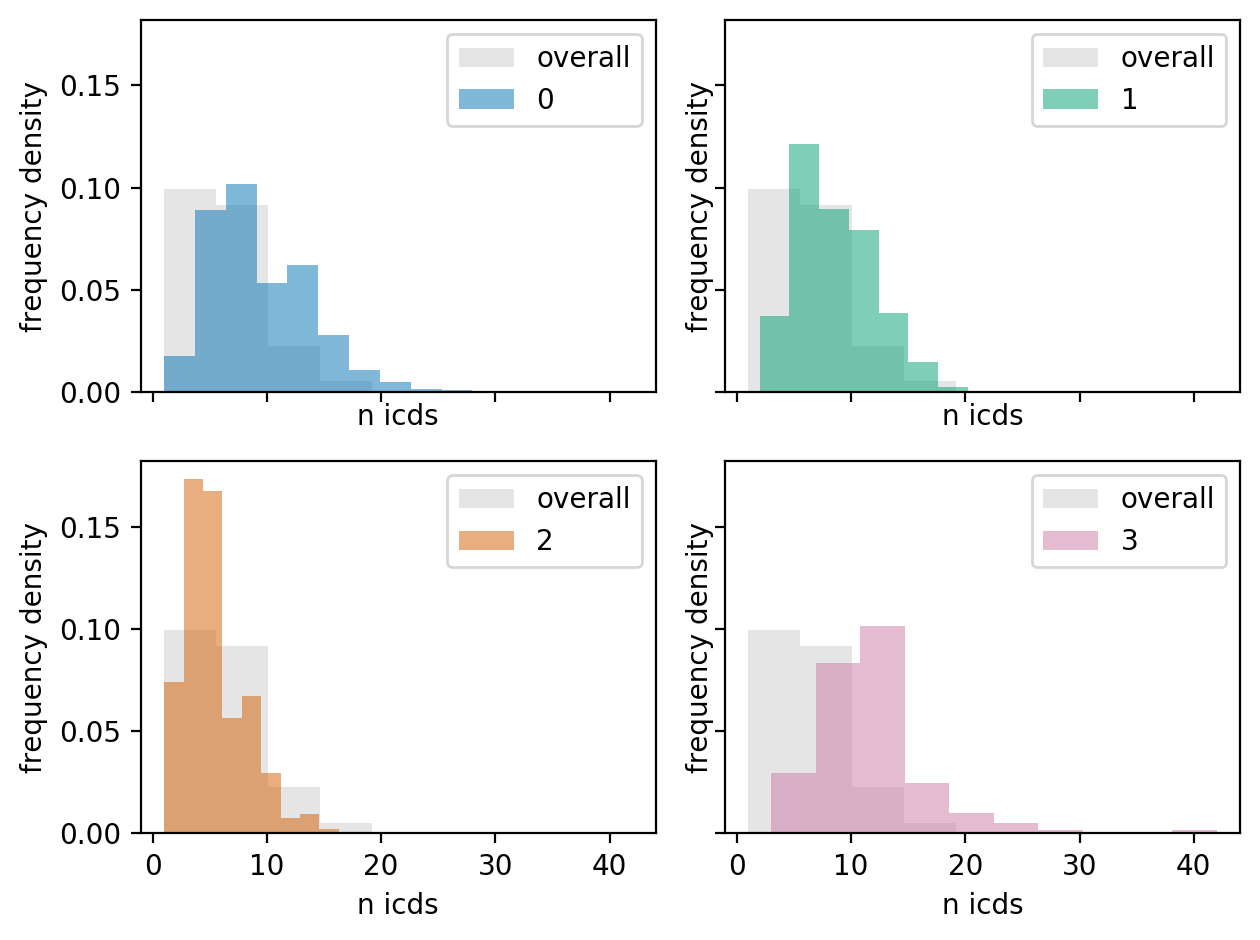

In [19]:
for col in [
    "wimd",
    "charlson_gross",
    "n_copd_admissions_last_year",
    "n_icds",
]:
    histograms(copd, col)


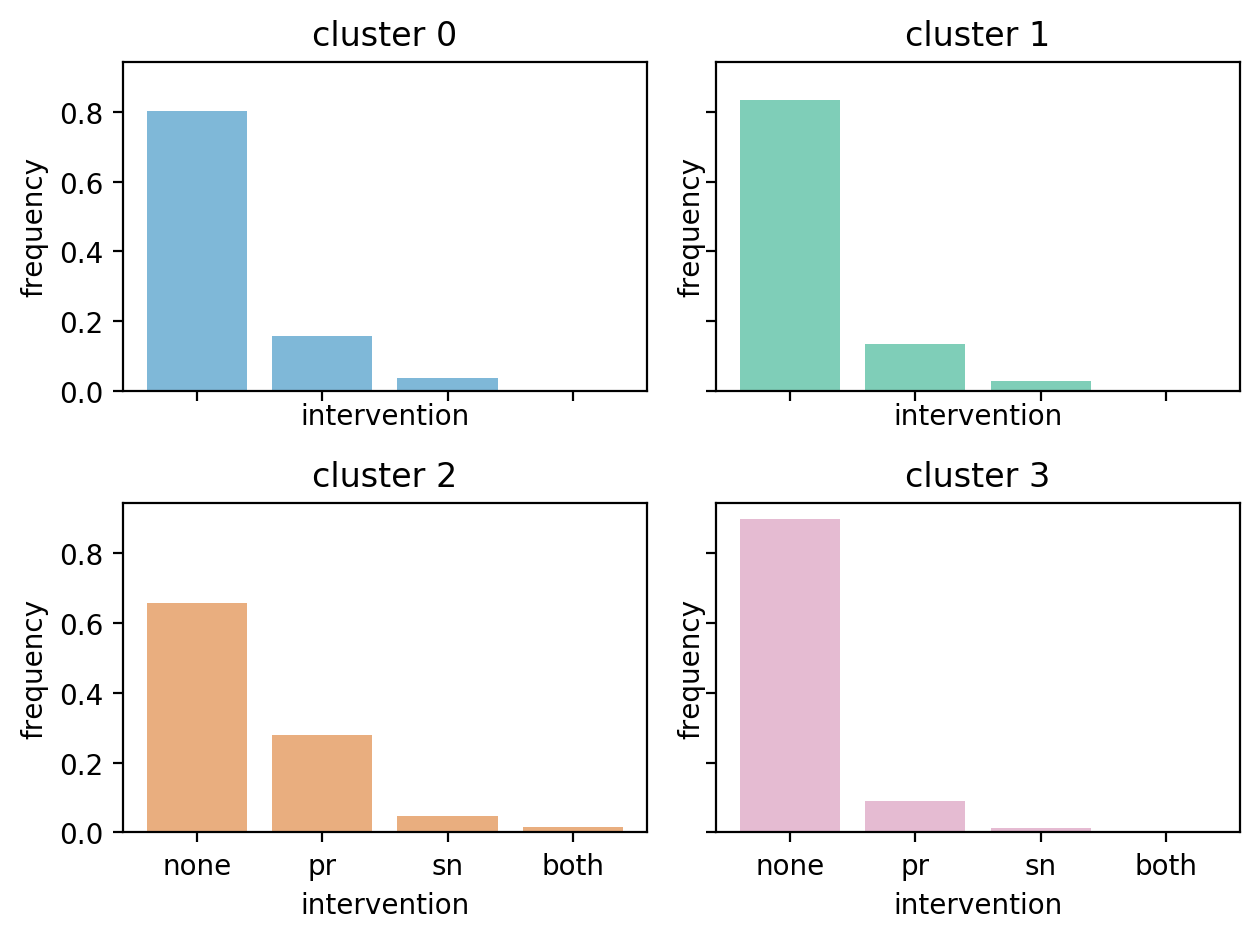

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

for (cluster, values), ax in zip(copd.groupby("cluster")["intervention"], axes):

    counts = values.value_counts(normalize=True).reindex(["none", "pr", "sn", "both"]).fillna(0)
    ax.bar(counts.index, counts.values, facecolor=colours[cluster], alpha=0.5)

    ax.set_xlabel("intervention")
    ax.set_ylabel("frequency")
    ax.set_title(f"cluster {cluster}")

plt.tight_layout()


In [101]:
cluster_attendances = {}
for label, cluster in copd.groupby("cluster"):
    cluster_attendances[label] = cluster.groupby("patient_id")["n_copd_admissions_last_year"].mean()

cluster_mean_lengths = {}
for label, cluster in copd.groupby("cluster"):
    cluster_mean_lengths[label] = cluster.groupby("patient_id")["true_los"].mean()

cluster_min_lengths = {}
for label, cluster in copd.groupby("cluster"):
    cluster_min_lengths[label] = cluster.groupby("patient_id")["true_los"].min()

cluster_max_lengths = {}
for label, cluster in copd.groupby("cluster"):
    cluster_max_lengths[label] = cluster.groupby("patient_id")["true_los"].max()

cluster_nicds = {}
for label, cluster in copd.groupby("cluster"):
    cluster_nicds[label] = cluster.groupby("patient_id")["n_icds"].median()
    
cluster_ltcs = {}
for label, cluster in copd.groupby("cluster"):
    cluster_ltcs[label] = cluster.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1)

cluster_charlsons = {}
for label, cluster in copd.groupby("cluster"):
    cluster_charlsons[label] = cluster.groupby("patient_id")["charlson_gross"].median()
    

In [102]:
cluster_characteristics = {}
for label in range(n_clusters):
    cluster_characteristics[label] = pd.concat(
        [
            cluster_attendances[label],
            cluster_min_lengths[label],
            cluster_mean_lengths[label],
            cluster_max_lengths[label],
            cluster_ltcs[label],
            cluster_nicds[label],
            cluster_charlsons[label],
        ],
        axis=1,
        sort=True,
    )

overall_characteristic = pd.DataFrame()
for label, cluster in cluster_characteristics.items():
    overall_characteristic[label] = cluster.mean().T

overall_characteristic["Population"] = (
    pd.concat(cluster_characteristics.values()).mean().T
)

overall_characteristic.index = [
    "COPD admissions last year",
    "Min. LOS",
    "Mean LOS",
    "Max. LOS",
    "No. of LTCs",
    "Median no. ICDs",
    "Median CCI",
]

overall_characteristic.index = [i + ", mean" for i in overall_characteristic.index]


In [103]:
cluster_conditions = {}
for cluster, data in copd.groupby("cluster"):
    cluster_conditions[cluster] = data.groupby("patient_id")[conditions].max().astype(bool)


In [104]:
overall_condition = pd.DataFrame()
for label, data in cluster_conditions.items():
    overall_condition[label] = data.mean().T * 100

overall_condition["Population"] = pd.concat(cluster_conditions.values()).mean().T * 100

overall_condition.index = [
    "Acute myocardial infection",
    "Stroke (CVA)",
    "Congestive heart failure",
    "Connective tissue disorder",
    "Dementia",
    "Diabetes",
    "Liver disease",
    "Peptic ulcer",
    "Peripheral vascualar disease",
    "Pulmonary disease",
    "Cancer",
    "Diabetic complications",
    "Paraplegia",
    "Renal disease",
    "Metastatic cancer",
    "Severe liver disease",
    "HIV",
    "C. diff",
    "MRSA",
    "Obesity",
    "Sepsis",
]

overall_condition.index = [i + ", %" for i in overall_condition.index]


In [106]:
summary = pd.concat(
    [overall_characteristic, overall_condition]
).round(3)

index = pd.MultiIndex.from_tuples(
    [
        *(("Characteristics", i) for i in overall_characteristic.index),
        *(("LTC Prevelance", i) for i in overall_condition.index),
    ]
)

columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population", "")]
)

summary.index = index
summary.columns = columns

summary

Cluster                    \
                                                       0        1        2   
Characteristics COPD admissions last year, mean    1.911    1.507    1.305   
                Min. LOS, mean                    24.321    5.679    2.931   
                Mean LOS, mean                    25.333    6.461    3.794   
                Max. LOS, mean                    26.469    7.340    4.825   
                No. of LTCs, mean                  2.048    3.099    1.469   
                Median no. ICDs, mean              9.644    8.707    5.438   
                Median CCI, mean                  11.305   21.647    5.722   
LTC Prevelance  Acute myocardial infection, %     14.269   23.419   10.842   
                Stroke (CVA), %                    9.670   15.010    1.185   
                Congestive heart failure, %       14.505   54.552    0.000   
                Connective tissue disorder, %      5.189    5.073    4.009   
                Dementia, %                        7.547   20.083    0.000   
                Diabetes, %                       20.165   28.700   16.717   
                Liver disease, %                   0.354    0.556    0.328   
                Peptic ulcer, %                    1.769    1.042    0.378   
                Peripheral vascualar disease, %    5.071    8.895    3.177   
                Pulmonary disease, %             100.000  100.000  100.000   
                Cancer, %                          8.019   13.760    4.110   
                Diabetic complications, %          0.236    0.695    0.328   
                Paraplegia, %                      1.297    3.961    0.252   
                Renal disease, %                   8.608   22.516    3.026   
                Metastatic cancer, %               1.769    5.768    0.000   
                Severe liver disease, %            0.236    0.625    0.000   
                HIV, %                             0.000    0.000    0.025   
                C. diff, %                         0.825    0.139    0.025   
                MRSA, %                            0.354    0.069    0.050   
                Obesity, %                         2.830    3.753    2.219   
                Sepsis, %                          2.123    1.251    0.252   

                                                         Population  
                                                       3             
Characteristics COPD admissions last year, mean    1.982      1.447  
                Min. LOS, mean                    74.060      8.058  
                Mean LOS, mean                    74.653      8.916  
                Max. LOS, mean                    75.316      9.918  
                No. of LTCs, mean                  2.702      1.941  
                Median no. ICDs, mean             11.728      6.878  
                Median CCI, mean                  18.179     10.334  
LTC Prevelance  Acute myocardial infection, %     16.556     14.257  
                Stroke (CVA), %                   19.205      5.840  
                Congestive heart failure, %       27.152     14.819  
                Connective tissue disorder, %      4.636      4.419  
                Dementia, %                       25.166      6.106  
                Diabetes, %                       25.828     20.081  
                Liver disease, %                   0.000      0.375  
                Peptic ulcer, %                    1.325      0.734  
                Peripheral vascualar disease, %    5.960      4.778  
                Pulmonary disease, %             100.000    100.000  
                Cancer, %                         10.596      6.949  
                Diabetic complications, %          1.987      0.437  
                Paraplegia, %                      0.662      1.234  
                Renal disease, %                  18.543      8.510  
                Metastatic cancer, %               0.662      1.546  
                Severe liver